In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from line_profiler import LineProfiler

import gaez_data_loader
import simulation
import toolbox
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)
importlib.reload(gaez_data_loader)

<module 'gaez_data_loader' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\gaez_data_loader.py'>

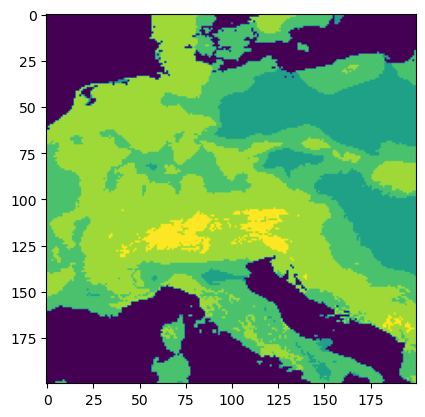

In [13]:
# Load Moisture regime data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Moisture_Regime_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)
gaez_data.set_woi(r0=400, c0=2200, n_rows=200, n_cols=200) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

moisture_data = np.copy(gaez_data._array)

plt.imshow(moisture_data) # visualize


 Loaded image has resolution:  (2160, 4320)

 Latitude cell size [km] for that image is:  9.25925925925926

 Latitude cell size [deg] for that image is:  0.08333333333333333


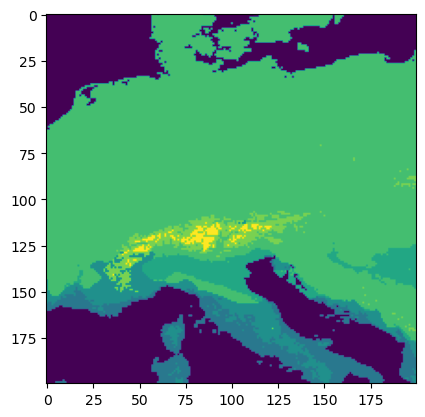

In [14]:
# Load Thermal regime data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Thermal_Regime_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=True)
gaez_data.set_woi(r0=400, c0=2200, n_rows=200, n_cols=200) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

temp_data = np.copy(gaez_data._array)

plt.imshow(temp_data) # visualize

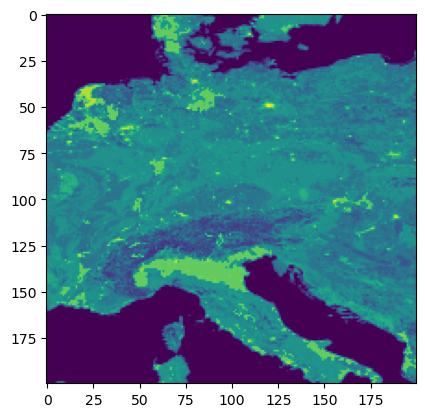

In [15]:
# Load Soil Data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Soil_Regime_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)
gaez_data.resize(target_size=(2160, 4320))  # shape of moisture and temperature class

gaez_data.set_woi(r0=400, c0=2200, n_rows=200, n_cols=200) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

soil_data = np.copy(gaez_data._array)

plt.imshow(soil_data) # visualize

Text(0.5, 1.0, 'Soil regime - Different')

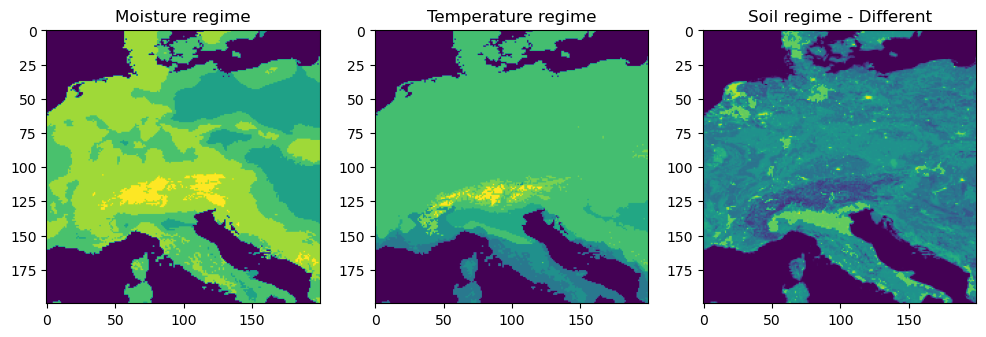

In [17]:
_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

ax1.imshow(moisture_data)
ax2.imshow(temp_data)
ax3.imshow(soil_data)

ax1.set_title("Moisture regime")
ax2.set_title("Temperature regime")
ax3.set_title("Soil regime - Different")